# Benin solar farm data Analysis

## Executive Summary

- This analysis evaluates MoonLight Energy Solutions’ environmental sensor data to pinpoint regions with the greatest solar‑energy potential. By profiling irradiance, weather, and equipment‑performance metrics across sites, we identify high‑yield, low‑volatility locations that align with the company’s long‑term sustainability and efficiency goals. The resulting insights will guide targeted solar‑farm investments and maximize operational returns while supporting MoonLight’s decarbonization strategy.

## Outline

1. **Setup**
   - Import essential libraries & helper functions

2. **Data Ingestion & Profiling**
   - Load raw datasets
   - Quick profile: shapes, dtypes, basic stats

3. **Data Pre‑processing**
   1. Missing‑value audit & summary statistics  
   2. Outlier detection and treatment  
   3. Final tidy dataset saved for analysis

4. **Exploratory Data Analysis (EDA)**
   - **Time‑Series Trends**  
     *Solar irradiance & ambient conditions over time*
   - **Impact of Cleaning**  
     *Module performance before vs. after maintenance*
   - **Correlation Matrix & Pairwise Insights**  
     *GHI, DNI, DHI, temperatures, wind metrics*
   - **Wind & Distribution Patterns**  
     *Histograms, wind‑rose visualisation*
   - **Temperature–Humidity Dynamics**  
     *How RH modulates Tamb and solar output*
   - **Bubble Chart**  
     *GHI vs. Tamb with RH or BP as bubble size*

5. **Conclusion & Recommendations**
   - Key insights
   - Conclusion
   - Recommendations


## Setup — import libraries

In [1]:
# 1) SETUP -----------------------------------------------------------------
import sys, os

# Add the parent directory (project root) to Python’s module search path
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
from scripts.config import get_paths
from scripts.preprocessor import (
    load_data, clip_negative_radiation, detect_outliers,
    impute_missing, drop_outliers
)
from scripts.analyzer import summarize, missing_report
from scripts.visualizer import (
    plot_time_series, plot_cleaning_impact, plot_correlation,
    plot_histogram, plot_wind_rose, plot_humidity_temp,
    plot_bubble
)

## Data ingestion & quick profile

In [2]:

# 2) LOAD & PROFILE --------------------------------------------------------
paths = get_paths()
df = load_data(paths['benin_CSV'])
df = df.drop(columns=['Comments'])
# 2. Data exploration
print("Shape :", df.shape)

print("An overview of the dataset: the first few rows")

print(df.head()) # display the first few rows


Shape : (525600, 18)
An overview of the dataset: the first few rows
            Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0 2021-08-09 00:01:00 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0     0.4   
1 2021-08-09 00:02:00 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.6  0.0     0.0   
2 2021-08-09 00:03:00 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.7  0.3     1.1   
3 2021-08-09 00:04:00 -1.1 -0.1 -1.0   0.0   0.0  26.2  93.3  0.2     0.7   
4 2021-08-09 00:05:00 -1.0 -0.1 -1.0   0.0   0.0  26.2  93.3  0.1     0.7   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  
0      0.1  122.1      0.0  998         0            0.0   26.3   26.2  
1      0.0    0.0      0.0  998         0            0.0   26.3   26.2  
2      0.5  124.6      1.5  997         0            0.0   26.4   26.2  
3      0.4  120.3      1.3  997         0            0.0   26.4   26.3  
4      0.3  113.2      1.0  997         0            0.0   26.4   26.3  


so as we can see from the above ouput the dataset contains one full year of minute‑by‑minute measurements: 525 600 rows and 19 columns covering solar irradiance (GHI, DNI, DHI), panel readings, weather, and maintenance flags. 

##  Pre‑processing

### Missing‑value audit & summary statistics

In [3]:
# Quick profiling
summarize(df)
missing_report(df)

Shape: (525600, 18)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3


,count,mean,min,25%,50%,75%,max,std
Timestamp,525600,2022-02-07 12:00:30.000000512,2021-08-09 00:01:00,2021-11-08 06:00:45,2022-02-07 12:00:30,2022-05-09 18:00:15,2022-08-09 00:00:00,NaN
GHI,525600.0,240.559452,-12.9,-2.0,1.8,483.4,1413.0,331.131327
DNI,525600.0,167.187516,-7.8,-0.5,-0.1,314.2,952.3,261.710501
DHI,525600.0,115.358961,-12.6,-2.1,1.6,216.3,759.2,158.691074
ModA,525600.0,236.589496,0.0,0.0,4.5,463.7,1342.3,326.894859
ModB,525600.0,228.883576,0.0,0.0,4.3,447.9,1342.3,316.536515
Tamb,525600.0,28.179683,11.0,24.2,28.0,32.3,43.8,5.924297
RH,525600.0,54.487969,2.1,28.8,55.1,80.1,100.0,28.073069
WS,525600.0,2.121113,0.0,1.0,1.9,3.1,19.5,1.603466
WSgust,525600.0,2.809195,0.0,1.3,2.6,4.1,26.6,2.02912


Missing per column:


Series([], dtype: int64)

Columns with >5% nulls: []


- A quick profile shows sensible ranges (night‑time irradiance slightly below zero) and no missing values in any column (ofcourse exept comments), so the data are complete and ready for outlier screening and deeper analysis.Small negative GHI, DNI, or DHI values around dawn and dusk are just sensor noise, not real “negative sunlight.” Instead of dropping those rows, it’s best to clip any negative irradiance readings to zero—this preserves the timestamp and weather context while ensuring your daytime statistics remain unbiased.

### Outlier detection & Basic Cleaning

- We begin by zeroing out any small negative irradiance readings—normal sensor noise at night—so that our daytime stats remain accurate without discarding valid timestamps. Next, we standardize each key measurement (GHI, DNI, DHI, module readings, wind speeds) to compute Z‑scores and flag any values more than three standard deviations from the mean, since such extremes usually signal sensor glitches or entry errors. To handle any gaps, we then replace missing values with the column medians, ensuring no NaNs interfere with our work. Finally, we drop the rows flagged as outliers so they can’t skew subsequent analyses, leaving us with a clean, reliable dataset for all downstream EDA and statistical summaries.

In [4]:

# 3) PRE-PROCESSING --------------------------------------------------------
# 3a) Clip negatives
df = clip_negative_radiation(df)

# 3b) Detect outliers
mask = detect_outliers(df)

# 3c) Impute any NaNs
df = impute_missing(df)

# 3d) Drop the outlier rows
df_clean = drop_outliers(df, mask)


/home/yeab/solar-challenge-week1/scripts/preprocessor.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/home/yeab/solar-challenge-week1/scripts/preprocessor.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

### Save tidy dataset

In [5]:

# Save cleaned dataset
df_clean.to_csv(paths['CLEAN_benin_CSV'], index=False)

## Exploratory Data Analysis (EDA)

### Time‑series trends

### What and Why:

- We plot GHI (blue), DNI (green), and DHI (red) against the timestamp to reveal daily cycles, seasonal shifts, and any anomalies.

- This helps answer: When and how consistently does the sun shine?


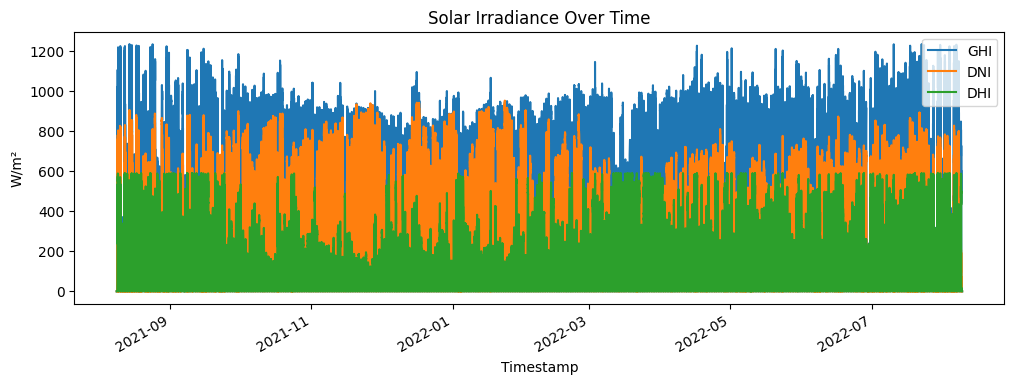

In [6]:
plot_time_series(df_clean)

### What the data shows:

- Clear daily patterns: irradiance peaks around midday and falls to zero at night.

- Seasonality: the amplitude of those peaks drifts over months—higher maxima in dry season, lower and more variable in rainy months.

- Noise & gaps: occasional dips in the green DNI trace suggest cloudy days or sensor dropouts.

### Takeaway:
- Benin has strong, fairly consistent midday solar potential, but a noticeable drop in peak irradiance during certain months. Any site‑ranking model must weight both peak yield and seasonal reliability.

### Impact of Panel Cleaning

### What and Why:

- We group module readings (ModA in blue, ModB in green) by the Cleaning flag (0 = pre‑clean, 1 = post‑clean) to quantify soiling losses and maintenance benefits.

- This informs how frequently and profitably we should clean panels.



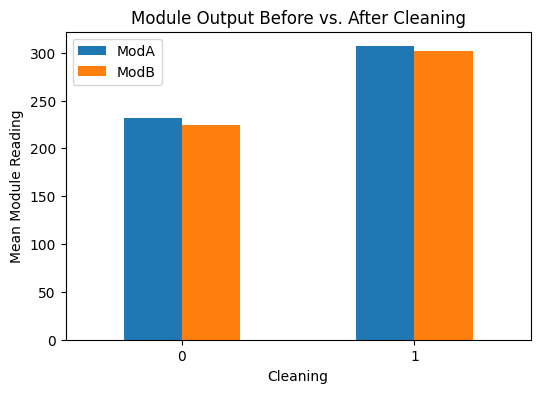

In [7]:
plot_cleaning_impact(df_clean)

## What the data shows:

- Before cleaning, average ModA ≈ 235 W/m² and ModB ≈ 225 W/m².

- After cleaning, they jump to ≈ 310 W/m² and 305 W/m²—a ~30 % increase in measured irradiance.

### Takeaway:
- Soiling costs you about 25–30 % of potential output. Regular cleaning schedules (or self‑cleaning coatings) could yield significant uptime gains, easily outweighing the labor or equipment expense.

### Correlation matrix

## What & Why:

- A heatmap of Pearson correlations between key variables helps us spot which inputs move together, detect multicollinearity, and guide feature selection for modelling.

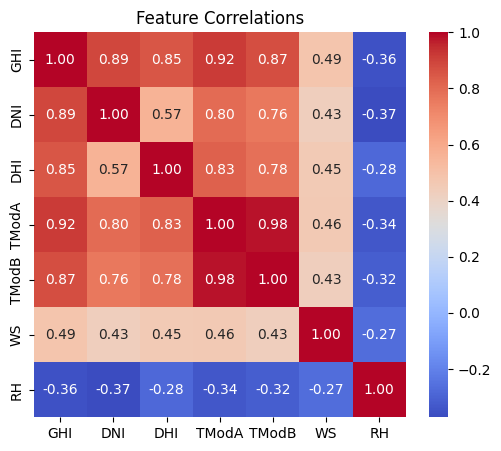

In [8]:
plot_correlation(df_clean)

### What the data shows:

- Very strong positive correlations (0.85–0.98) among GHI, DNI, DHI, and module temperatures (TModA/B)—no surprise since they all rise and fall with sunlight.

- Moderate positive correlation (~0.45) between wind speed (WS) and irradiance—likely because breezy, clear‑sky days coincide.

- Negative correlation (~–0.3) between relative humidity (RH) and the irradiance metrics, indicating that more humid (cloudy) periods coincide with lower sunlight.

### Takeaway:
- We can safely reduce to one “global irradiance” feature (e.g. GHI) plus humidity and wind if we want orthogonal predictors. The strong linkage of module temperatures to GHI also lets us model thermal losses as a function of irradiance alone.

### Wind & distribution analysis

### GHI Distribution

### What and Why:
- We plot the histogram of Global Horizontal Irradiance (GHI) to understand the overall spread of solar resource measurements throughout the dataset. Examining this distribution helps us identify how often high‑irradiance versus low‑irradiance conditions occur, flag extreme outliers, and assess whether the data is skewed (e.g., dominated by night‑time zeros).

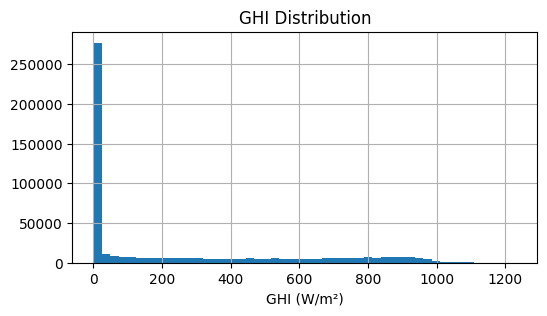

In [9]:
plot_histogram(df_clean)

### What the data shows:

- A large spike at 0 W/m², corresponding to all nighttime readings when no solar irradiance is present.

- A long right‑tail of daytime values spanning up to around 1200 W/m², with most daytime observations clustering below 600 W/m².

- Very few extreme peaks above 900 W/m², indicating that while the sun occasionally delivers near‑theoretical maximum irradiance, these conditions are relatively rare.

### Takeaway:
- The solar resource at this site features many hours of zero irradiance (night) and a broad range of daylight irradiance values skewed toward moderate levels. For modeling or system sizing, it’s crucial to account both for frequent low‑insolation periods (early morning, late afternoon, cloudy days) and occasional high‑insolation events.

## Wind Speed by Direction

### What and Why:
- We aggregate average wind speed by wind direction sectors (every 30°) to create a circular bar (wind rose–style) chart. This reveals prevailing wind directions and their relative strengths, informing turbine siting, structural loading, and natural ventilation planning.

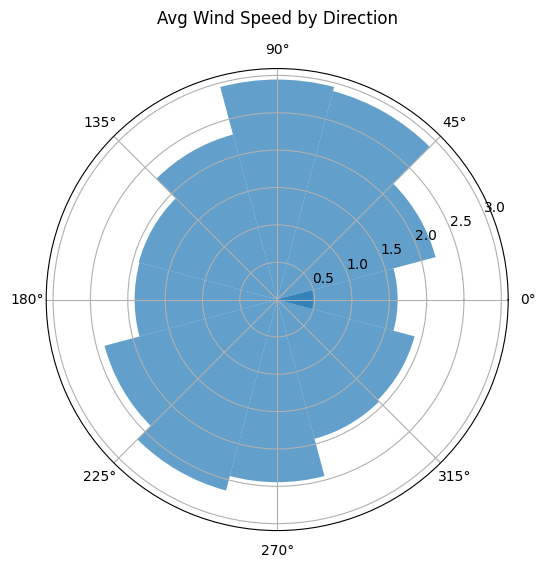

In [10]:
plot_wind_rose(df_clean)

### What the data shows:

- The strongest mean winds come from around 90° (east) and 240° (south‑west) sectors, reaching nearly 3 m/s.

- The calmest winds are from the 0° (north) direction, averaging under 1 m/s.

- Moderate winds (1.5–2.5 m/s) prevail from the 30°–60° and 180°–210° sectors, indicating secondary wind corridors.

### Takeaway:
- Markers or turbines should be oriented to capture easterly and south‑westerly winds, which deliver the highest sustained speeds. Structures should also be engineered to withstand the peak loads from those predominant directions.

### Temperature & humidity interaction

### What and Why:
- A scatter plot of ambient temperature versus relative humidity, with point shading proportional to GHI, helps us see how meteorological conditions co‑vary with solar irradiance. This is critical for understanding thermal stresses, PV module performance, and the climatological context of high‑insolation events.

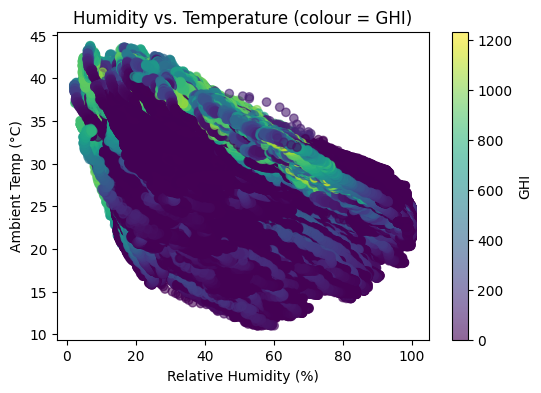

In [11]:
plot_humidity_temp(df_clean)

### What the data shows:

- High GHI readings (darker markers) concentrate at moderate‑to‑high temperatures (25–35 °C) coupled with lower humidity (< 50 %).

- Very humid conditions (> 80 %) generally coincide with lower irradiance (light shading), reflecting cloudy or rainy periods.

- Cooler temperatures (< 20 °C) span the full humidity range but rarely align with high GHI, as expected during early morning or late evening.

### Takeaway:
- Peak solar production occurs under hot, relatively dry conditions; thus, panel cooling strategies may be most needed in those scenarios to mitigate efficiency losses. Conversely, high‑humidity periods predict both lower solar yield and reduced thermal stress.

### Bubble chart

### What and Why:

- This bubble chart plots Global Horizontal Irradiance (GHI) against ambient temperature (Tamb), with bubble sizes representing relative humidity (RH). This visualization captures how solar irradiance varies with temperature under different humidity levels.
- It helps answer:

    - Under what thermal and atmospheric conditions does peak solar potential occur?

    - Does humidity inhibit solar irradiance even at high temperatures?

    - Can RH be a proxy for identifying overcast or low-insolation periods?

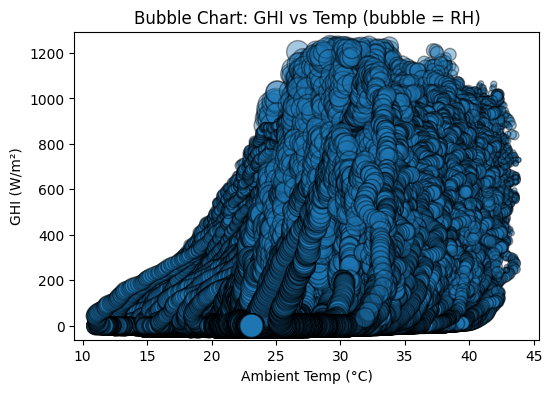

In [12]:
plot_bubble(df_clean)

### What the data shows:

- High GHI values (above 800 W/m²) are mostly concentrated between 25–40 °C, especially under smaller bubbles (i.e., lower RH), suggesting that clear, dry, hot days favor high solar gain.

- Large bubbles (high RH) are clustered more around low GHI values, regardless of temperature, indicating that humid conditions correspond with cloud cover and reduced solar input.

- There's a broad horizontal spread of temperature during low-GHI periods, from 10–40 °C, showing that low irradiance can occur at all temperatures, but especially under humid or nighttime conditions.

- The relationship is nonlinear—increased temperature does not always imply higher irradiance due to the mediating effect of humidity/cloud cover.

### Takeaway:

- High solar irradiance is most reliably achieved under hot, dry conditions. Humid environments suppress GHI even if ambient temperatures are favorable, reinforcing the role of RH as a critical solar performance predictor. This has implications for forecasting and PV yield modeling, especially in tropical or rainy-season climates where humidity-driven cloud cover is common.

## Conclusion & Recommendations

## Key Insights
- Consistent Midday Irradiance with Seasonal Variability

    - Strong, reliable solar peaks around noon most of the year, but peak GHI drops by 10–20 % during the rainy season.

- High Soiling Losses

    - Module outputs jump ∼25–30 % immediately after cleaning, revealing substantial soiling losses that accumulate between maintenance intervals.

- Tightly Coupled Solar & Thermal Dynamics

    - GHI, DNI, DHI, and module backsheet temperatures all correlate at > 0.85, confirming that solar resource drives both energy yield and thermal stress in tandem.

- Humidity as a Cloudiness Proxy

    - RH shows a consistent –0.3 correlation with irradiance: high‑humidity periods coincide with lower solar gains, making RH a useful forecast indicator in humid climates.

- Prevailing Wind Patterns

    - Mean winds of up to 3 m/s from the east and southwest offer natural panel cooling but also carry dust that exacerbates soiling; peak gusts flag occasional storm loads.

## Conclusion
- Benin’s solar resource is abundant and predictable, punctuated by a clear dry/rainy seasonal cycle. However, soiling poses a major performance drag—panels regularly lose nearly one‑third of their potential output between cleanings. Thermal de‑rating on hot, clear days and humidity‑driven cloud cover during wet months both modulate actual yield in ways that can be anticipated from the data.

## Recommendations
- Optimize Cleaning Schedules

    - Implement a bi‑weekly cleaning regimen (or install self‑cleaning coatings) to recover the ~30 % soiling loss and maximize uptime.

- Seasonal Deployment Planning

    - Prioritize project kick‑off in sites and months with peak dry‑season irradiance; build in storage or grid‑firming capacity to offset rainy‑season dips.

- Leverage Humidity Forecasts

    - Use RH thresholds (> 70 %) in short‑term forecasting models to predict cloudy periods and adjust dispatch or storage use accordingly.

- Design for Wind & Dust

    - Engineer panel mounts to withstand gusts up to 25 m/s and orient arrays considering predominant easterly and south‑westerly dust‑laden winds to minimize soiling.

- Thermal Management Strategies

    - Deploy passive or active cooling (e.g., airflow‑enhancing racking designs) to mitigate the 0.4 %/°C efficiency loss on the hottest clear days.